In [1]:
# -*- coding: utf-8 -*-
"""
@author: Etienne Kras, open in bathymetry_env
"""

# imports 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import gdal
import os
import ee
import osr
import geemap
import geojson
import datetime
import time
import matplotlib.dates as mdates
import multiprocess.context as ctx
import logging
import itertools
ee.Initialize()
logging.basicConfig()

from geojson import Feature, FeatureCollection, dump
from shapely.geometry import Polygon
from dateutil.relativedelta import *
from google.cloud import storage
#from eepackages.applications import bathymetry
from pathlib import Path
#from eepackages.utils import download_image_collection, download_image_collection_thumb
#from eepackages.assets import getMostlyCleanImages, getImages

# coordinate conversions
SR4326 = osr.SpatialReference()
SR4326.ImportFromEPSG(4326)     # WGS84 / Geographic
SR3857 = osr.SpatialReference()
SR3857.ImportFromEPSG(3857)     # WGS84 / Pseudo-Mercator
ct_4326_to_3857 = osr.CoordinateTransformation(SR4326, SR3857)
ct_3857_to_4326 = osr.CoordinateTransformation(SR3857, SR4326)

In [2]:
# mounting the required functionality from locally adjusted cloned source code (API debugging)
import sys
from pathlib import Path

sys.path.append(str(Path(r'C:\Users\kras\Documents\GitHub') / "ee-packages-py"))
from eepackages.applications import bathymetry
from eepackages.utils import download_image_collection, download_image_collection_thumb
from eepackages.assets import getMostlyCleanImages, getImages

# REINSTALL EEPACKAGES AFTER THE PULL REQUEST IS MERGED AND THE VERSION BUMPED 

TO DO:
- add turbidity / algae assessment on single images present in composites to allow for oceanic corrections, incorporate in the API later on
- add num_images into image_collection exports variables to speed up mutliprocessing

# Project specific toggles

In [8]:
# see scheme at acces_api.pdf for a workflow visualization 

# project toggles
main_fol = r'p:\11204209-jip-calm\WT4.1_SDB' # name of the local folder to store files locally
bucket = 'jip_calm_sdb' # name of the Google Cloud Storage bucket to store files in the cloud
credential_file = r'p:\11204209-jip-calm\WT4.1_SDB\GEE_images\jip-calm-c1886b3313b9.json' # Cloud Storage credential key
overall_project = 'WaddenSea' # name of the overall project (regional AoI)
project_name = 'Friese_Zeegat' # name of the project AoI (local AoI)
assessment = 'Subtidal' # either subtidal or intertidal 
draw_AoI = 0 # toggle 1 to draw AoI, 0 to load
plot_indic = 0 # make indicative plot
store_single = 1 # toggle 1 to store single (best & worst) images, else 0

# composite image toggles
start_date = '2015-01-01' # start date of the composites
stop_date = '2022-01-01' # end date of the composites
compo_int = 3 # composite interval [months]
compo_len = 12 # composite length [months]
scale = 19.109  # output resolution of the image [m]

# Pre-processing

In [5]:
# draw or load Area of Interest (AoI)

Map = geemap.Map(center=(52.643246, 5.060993), zoom=8) # initialize map with base in Hoorn

if draw_AoI == 1:
    print('Please draw a polygon somewhere in a water body') # identifier
if draw_AoI == 0:
    # open AoI
    print('Loading and visualizing AoI') #identifier
    AoIee = geemap.geojson_to_ee(os.path.join(main_fol,'AOI\local',project_name+'.geojson'))
    Map.addLayer(AoIee, {}, 'AoI')
    Map.setCenter(lon=AoIee.geometry().centroid().getInfo()['coordinates'][0], 
                  lat=AoIee.geometry().centroid().getInfo()['coordinates'][1], zoom=8) # center around loaded AoI

Map # show map

Loading and visualizing AoI


Map(center=[53.46655772475182, 6.04182799999971], controls=(WidgetControl(options=['position', 'transparent_bg…

In [6]:
# (re)construct the AoI

if draw_AoI == 1:
    
    print('Constructing AoI from drawn polygon') # identifier
    
    # get AoI 
    AoIee = ee.FeatureCollection(Map.draw_features) # make featurecollection
    AoI = Polygon(AoIee.getInfo()['features'][0]['geometry']['coordinates'][0]) # create AoI shapefile

    # export AoI
    features = []
    features.append(Feature(geometry=AoI, properties={"AoI": project_name}))
    feature_collection = FeatureCollection(features)
    with open(os.path.join(main_fol,'AOI\local',project_name+'.geojson'), 'w') as f: # geojson
        dump(feature_collection, f)
    AoI_conv = Polygon([list(ct_4326_to_3857.TransformPoint(i[1], i[0])[0:2]) for i in AoIee.getInfo()['features'][0]['geometry']['coordinates'][0]]) # to EPSG 3857  
    gdr = gpd.GeoDataFrame({'properties':{'AoI': project_name}, 'geometry': AoI_conv}, crs='EPSG:3857') #shp
    gdr.to_file(os.path.join(main_fol,'AOI\local',project_name+'.shp'),encoding='UTF-8')
    bounds = ee.Geometry.Polygon([[[a,b] for a, b in zip(*AoI.exterior.coords.xy)]])
    
if draw_AoI == 0:
    print('Reconstructing AoI from loaded file')
    # get AoI
    with open(os.path.join(main_fol,'AOI\local',project_name+'.geojson')) as f:
        AoIjson = geojson.load(f)
    try: # drawn polygon in this script
        AoI = Polygon(AoIjson['features'][0]['geometry']['coordinates'][0]) 
    except: # drawn in QGIS / ArcGIS and written to geojson there (client file)
        AoI = Polygon(AoIjson['features'][0]['geometry']['coordinates'][0][0])
    bounds = ee.Geometry.Polygon([[[a,b] for a, b in zip(*AoI.exterior.coords.xy)]])

Reconstructing AoI from loaded file


# Feasibility study

In [7]:
# image timeframes (time-marcher)
sdate = datetime.datetime.strptime(start_date,'%Y-%m-%d')
edate = datetime.datetime.strptime(stop_date,'%Y-%m-%d')
window_length = int((edate.year-sdate.year)*12+(edate.month-sdate.month))
srangedates = pd.date_range(start_date, freq='%sMS'%(compo_int), periods=int((window_length-compo_len)/3)+1).strftime('%Y-%m-%d').tolist()
erangedates = pd.date_range((sdate+relativedelta(months=compo_len)).strftime('%Y-%m-%d'), freq='%sMS'%(compo_int), periods=int((window_length-compo_len)/3)+1).strftime('%Y-%m-%d').tolist()

In [9]:
# export best and worst single images within each composite window to get insight into and tune the cloud frequency threshold
if store_single == 1:
    ctx._force_start_method('spawn')
    sdb = bathymetry.Bathymetry() # initialize sdb instance (class)
    c_thresh = 0.15
       
    b_img_list = [] # best images
    w_img_list = [] # worst images
    for starts, ends in zip(srangedates, erangedates):
        image = sdb.compute_inverse_depth(
            bounds=bounds,
            start=starts,
            stop=ends,
            scale=scale,
            missions=['S2', 'L8'],
            cloud_frequency_threshold_data = c_thresh, # cloud fequency threshold, higher means harder threshold for included imgs
            filter_masked=True,
            skip_neighborhood_search=False,
            s2merge='dd', # filter S2 image duplicates rounded on days (dd)
        ).clip(bounds) # clip to bounds 
        
        imgCol = sdb._raw_images.select('red', 'green', 'blue').map(lambda img: img.clip(bounds)) # check with imgCol.size().getInfo()
        imgCol_list = imgCol.toList(imgCol.size())
        b_img_list.append(ee.Image(imgCol_list.get(0))) # best image included
        w_img_list.append(ee.Image(imgCol_list.get(-1))) # worst image included 
    
    bimg_col = ee.ImageCollection(b_img_list)
    wimg_col = ee.ImageCollection(w_img_list)
    bimg_col_time = bimg_col.aggregate_array('system:time_start').getInfo() # filter the times of the best images
    wimg_col_time = wimg_col.aggregate_array('system:time_start').getInfo() # filter the times of the worst images
    
    # create or check if local storage folder is present
    if not os.path.exists(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'single_images')):
        os.makedirs(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'single_images'))
        
    # download and store remaining cloud filtered (best and worst; i.e. first and last) images in the composite imageCollection windows (takes a while..)
    # note, for each exported single image, the number behind the name_prefix is equal to miliseconds since 1970
    #download_image_collection(bimg_col, out_dir=Path(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'single_images')),
    #                          name_prefix='best_images_', download_kwargs={"format": "GEO_TIFF", "scale": 30, "crs": "EPSG:3857"}) # scale
    download_image_collection_thumb(bimg_col, out_dir=Path(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'single_images')),
                                    name_prefix='best_images_', download_kwargs={"format": "PNG","min": [0, 0, 0],"max": [0.3, 0.3, 0.3],"scale": 30}) # scale
    
    #download_image_collection(wimg_col, out_dir=Path(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'single_images')),
    #                          name_prefix='worst_images_', download_kwargs={"format": "GEO_TIFF", "scale": 30, "crs": "EPSG:3857"}) # scale
    download_image_collection_thumb(wimg_col, out_dir=Path(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'single_images')),
                                    name_prefix='worst_images_', download_kwargs={"format": "PNG","min": [0, 0, 0],"max": [0.3, 0.3, 0.3],"scale": 30}) # scale

In [10]:
# mimic the steps in the compositing method to get insights and assess feasibility, this takes a while..

# total number of images detected
imgs_list = []
time_list = []
ids_list = []
for i, j in zip(srangedates, erangedates):

    # get the total number of images in the AoI
    imgs = getImages(bounds, {
                "missions": ['S2','L8'],
                "filter": ee.Filter.date(i, j), 
                "filterMasked": True, # 100% coverage
                "scale": ee.Number(scale).multiply(10), 
                "resample": True,
                "s2TimeMerger": 'dd' # filter S2 image duplicates rounded on days (dd)
    })
    imgs_list.append(imgs)

    # export the timestamps
    time_list.append(imgs.aggregate_array('system:time_start').getInfo())
    ids_list.append(imgs.aggregate_array('MISSION').getInfo())
    
# rewrite to single list images without duplicates
time_total = list(itertools.chain(*time_list))
ids_total = list(itertools.chain(*ids_list))
time, idx_un = np.unique(time_total, return_index=True)
ids = [ids_total[index] for index in idx_un]

# filtered number of images detected (clouds)
fil_imgs_list = []
fil_time_list = []
fil_ids_list = []
for imgs in imgs_list:

    # filter the images on cloud cover and sort on quality score (green band based, lower means better), per composite window
    fil_imgs = getMostlyCleanImages(ee.ImageCollection(imgs), bounds, {
                "cloudFrequencyThresholdDelta": c_thresh # higher means lowering the number of incorporated cloudy images
            }) # note, Modis Clouds are used as local cloudcover as ESA or NASA global cloud cover is insufficient
    fil_imgs_list.append(fil_imgs)

    # export the timestamps
    fil_time_list.append(fil_imgs.aggregate_array('system:time_start').getInfo())
    fil_ids_list.append(fil_imgs.aggregate_array('MISSION').getInfo())
    
# rewrite to single list images without duplicates
fil_time_total = list(itertools.chain(*fil_time_list))
fil_ids_total = list(itertools.chain(*fil_ids_list))
fil_time, fil_idx_un = np.unique(fil_time_total, return_index=True)
fil_ids = [fil_ids_total[index] for index in fil_idx_un]

# export all single images in a composite window to check correctness
#check = fil_imgs_list[0].select('red', 'green', 'blue').map(lambda img: img.clip(bounds))
#download_image_collection_thumb(check, out_dir=Path(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'single_images/check')),
#                                name_prefix='check_images_', download_kwargs={"format": "PNG","min": [0, 0, 0],"max": [0.3, 0.3, 0.3],"scale": 30}) # scale
#download_image_collection(check, out_dir=Path(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'single_images/check')),
#                          name_prefix='check_images_', download_kwargs={"format": "GEO_TIFF", "scale": 30, "crs": "EPSG:3857"})
 
# get insight in best and worst images per timestep and their the exact times
#for tt, bt, wt in zip(fil_time_list, bimg_col_time, wimg_col_time):
#    print(len(tt), bt, wt, datetime.datetime.fromtimestamp(bt/1000), datetime.datetime.fromtimestamp(wt/1000))

# possible extension on the sequential filtering of turbid images.. (i.e. oceanic noise)

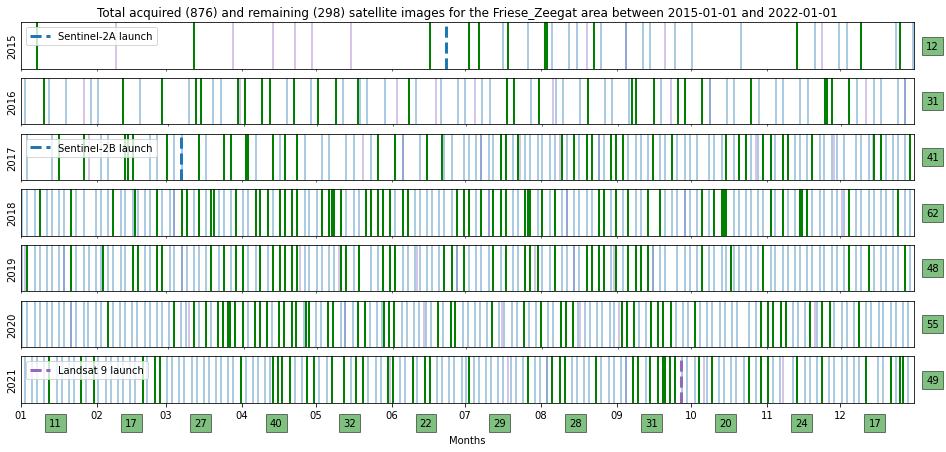

In [11]:
# figure on total acquired and remaining satellite images in the composites (allows for feasibility assessment)
fig, axs = plt.subplots(int(stop_date[0:4])-int(start_date[0:4]),1, figsize=(16, int(stop_date[0:4])-int(start_date[0:4])))
axs[0].set_title('Total acquired (%s) and remaining (%s) satellite images for the %s area between %s and %s'%(str(len(ids)), str(len(fil_ids)), project_name, start_date, stop_date))

# formatting the outlook of the image
for idx, i in enumerate(axs):
    axs[idx].set_ylabel(str(int(start_date[0:4])+idx)) # insert y labels
    axs[idx].set_yticks([]) # get rid of y axis ticks
    if idx != len(axs)-1: # only leave last axis x ticks on
        axs[idx].set_xticks([])
    if idx == len(axs)-1: # set x label
        axs[idx].set_xlabel('Months', labelpad=15);
    axs[idx].xaxis.set_minor_locator(mdates.MonthLocator())
    axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    axs[idx].set_xlim(datetime.datetime(int(start_date[0:4])+idx, 1, 1), datetime.datetime(int(start_date[0:4])+idx, 12, 31))
    axs[idx].set_ylim(0,1)
    
    # incorporate image data (all images)
    for i, j in zip(time, ids):
        time_conv = datetime.datetime.fromtimestamp(i/1000)#.strftime('%Y-%m-%d') # /1000 as it is in miliseconds 
        if j == 'S2':
            axs[idx].axvline(time_conv,color='tab:blue',alpha=0.5)
        if j == 'L8':
            axs[idx].axvline(time_conv,color='tab:purple',alpha=0.5)
            
    # incorporates image data (cloud-filtered images)
    count = 0
    for i, j in zip(fil_time, fil_ids):
        time_conv = datetime.datetime.fromtimestamp(i/1000)#.strftime('%Y-%m-%d') # /1000 as it is in miliseconds 
        if time_conv >= datetime.datetime(int(start_date[0:4])+idx, 1, 1) and time_conv < datetime.datetime(int(start_date[0:4])+idx, 12, 31):
            axs[idx].axvline(time_conv,color='g',alpha=1,linewidth=2)
            count = count + 1
        
    # horizontal counter (per year)
    axs[idx].text(datetime.datetime(int(start_date[0:4])+idx+1, 1, 5), 0.43, '%02d'%count, ha='left', 
                  bbox={'facecolor': 'g', 'alpha': 0.5})

# vertical counter (per month)
df = pd.DataFrame() # empty dataframe
convs_month = [] # filter the months
for i, j in zip(fil_time, fil_ids):
    convs_month.append(datetime.datetime.fromtimestamp(i/1000).month)
df = pd.DataFrame({'month':convs_month, 'score':np.ones(len(convs_month), dtype=int)}) # append months and single score
g = df.groupby('month') # grouper
month_counter = g['score'].sum() # summer
for idv, i in enumerate(month_counter):
    if idx == len(axs)-1: # only for lower axis
        axs[idx].text(datetime.datetime(int(stop_date[0:4])-1, idv+1, 15), -0.5, '%02d'%i, ha='center', 
                      bbox={'facecolor': 'g', 'alpha': 0.5})
    
# satellite launches
axs[2015-int(start_date[0:4])].axvline(datetime.datetime(2015, 6, 23), label='Sentinel-2A launch', color='tab:blue', linestyle='--', linewidth=3)
axs[2015-int(start_date[0:4])].legend()
axs[2017-int(start_date[0:4])].axvline(datetime.datetime(2017, 3, 7), label='Sentinel-2B launch', color='tab:blue', linestyle='--', linewidth=3)
axs[2017-int(start_date[0:4])].legend()
axs[2021-int(start_date[0:4])].axvline(datetime.datetime(2021, 9, 27), label='Landsat 9 launch', color='tab:purple', linestyle='--', linewidth=3)
axs[2021-int(start_date[0:4])].legend()

# save the image (and check if we need to make a folder)
if os.path.exists(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'python_images')) == False:
    os.mkdir(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'python_images'))

plt.savefig(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'python_images', 'overview_satellite_images_cloud_thresh_%s.png'%str(c_thresh)), bbox_inches='tight', facecolor='white');

# Construct composites using the API

In [21]:
# create (subtidal) composites within AoI
# for intertidal assessment see for example: 
# https://github.com/openearth/eo-bathymetry/blob/master/notebooks/rws-bathymetry/intertidal_bathymetry.ipynb
sdb = bathymetry.Bathymetry() # initialize sdb instance (class)

# save composite ee.Images to a list (note, these are not yet processed)
image_list = []
image_comp = []
for starts, ends in zip(srangedates, erangedates):
    
    image = sdb.compute_inverse_depth(
        bounds=bounds,
        start=starts,
        stop=ends,
        scale=scale,
        missions=['S2','L8'],
        cloud_frequency_threshold_data = 0.15, # cloud fequency threshold, higher means harder threshold for included imgs
        filter_masked=True,
        skip_neighborhood_search=False,
        s2merge='dd', # filter S2 image duplicates rounded on days (dd)
    ).clip(bounds) # clip to bounds 
    
    image_list.append(image)
    image_comp.append(sdb._raw_images.size())

In [24]:
# download and store composites to .png files 

# create or check if local storage folder is present
if not os.path.exists(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'composites')):
    os.makedirs(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'composites'))

# tweak single image high volume export into the export of composites (takes a while..) and only works if ImageCollection is not too large 
for i in range(len(image_list)):
    if i == 10:
        comp_col = ee.ImageCollection(image_list[i:i+1])
        comp_col_red = comp_col.select('red', 'green', 'blue').map(lambda img: img.clip(bounds))
        download_image_collection_thumb(comp_col_red, out_dir=Path(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 'composites')),
                                    name_prefix='composite_images_%s_'%str(i+1), download_kwargs={"format": "PNG","min": [0, 0, 0],"max": [1, 1, 1],"scale": 30}) # scale

In [12]:
# show image (indicative)
# note, this takes a while as image is processed in the cloud first

if plot_indic == 1:
    AoIcenter = AoIee.geometry().centroid().coordinates()
    Map = geemap.Map(center=(AoIcenter.get(1).getInfo(), AoIcenter.get(0).getInfo()), zoom=12) 
    Map.addLayer(AoIee, {}, 'AoI')
    Map.addLayer(image.select('red'), {}, 'composite')#, { "min": min, "max": max }, 'red-green-blue')
    Map 

In [24]:
# store composites in assets or in cloud buckets (depending on your preference)
store_asset = 1 # toggle 1 to save to asset imageCollection in Google Earth Engine (user account)
store_gcs = 1 # toggle 1 to save to Google Cloud Storage (GCS) (user account), for service account GCS see for example: 
# https://github.com/openearth/eo-bathymetry/blob/master/notebooks/rws-bathymetry/test_service_user.ipynb

# to assets --> visualize in Code Editor UI
if store_asset == 1:
    
    # get user info from the server
    user_name = ee.data.getAssetRoots()[0]["id"].split("/")[-1]
    asset_id = f'users/{user_name}/%s/%s/%s'%(assessment, overall_project, project_name)

    # create folder
    try:
        ee.data.createAsset({'type': 'Folder'}, '/'.join(asset_id.split('/')[:-2]))
    except:
        print('Asset folder was already created, cannot overwrite')
        
    # create subfolder
    try:
        ee.data.createAsset({'type': 'Folder'}, '/'.join(asset_id.split('/')[:-1]))
    except:
        print('Asset subfolder was already created, cannot overwrite')    
    
    # create empty imageCollection
    try: 
        ee.data.createAsset({'type': 'ImageCollection'}, asset_id)
    except:
        print('Asset imageCollection was already created, cannot overwrite')
    
    # start ingesting images into imageCollection
    cl_lens = []
    for idx, (img, cl, start, end) in enumerate(zip(image_list, image_comp, srangedates, erangedates)):
        cl_lens.append(cl.getInfo()) # number of included images in the composite
        task = ee.batch.Export.image.toAsset(**{
            'image': img,
            'description': '%s_%s_%s_%s_%s_%s_%s'%(project_name, start, end, str(int(scale)), str(compo_len), str(compo_int), 
                                                str(cl_lens[idx])),
            'scale': scale,
            'region': bounds,
            'assetId': asset_id + '/%s_%s_%s_%s_%s_%s_%s'%(project_name, start, end, str(int(scale)), str(compo_len), str(compo_int),
                                                        str(cl_lens[idx])),
            'maxPixels': 1e11,
            'crs': 'EPSG:3857'
        })
        task.start()
        
    print('tasks submitted, check progress at: https://code.earthengine.google.com/tasks')

# to cloud storage 
if store_gcs == 1:
    cl_lens = []
    for idx, (img, cl, start, end) in enumerate(zip(image_list, image_comp, srangedates, erangedates)):
        cl_lens.append(cl.getInfo()) # number of included images in the composite
        task = ee.batch.Export.image.toCloudStorage(**{
            'image': img, 
            'description': '%s_%s_%s_%s_%s_%s_%s'%(project_name, start, end, str(int(scale)), str(compo_len), str(compo_int), 
                                                str(cl_lens[idx])),
            'scale': scale,
            'region': bounds,
            'fileNamePrefix': '%s/%s/%s/%s_%s_%s_%s_%s_%s_%s'%(assessment, overall_project, project_name, project_name, start, end,
                                                             str(int(scale)), str(compo_len), str(compo_int), str(cl_lens[idx])),
            'fileFormat': 'GeoTIFF',
            'bucket': bucket, 
            'formatOptions': {'cloudOptimized': True}, # enables easy QGIS plotting
            'maxPixels': 1e11,
            'crs': 'EPSG:3857',
        })
        task.start()
        
    print('tasks submitted, check progress at: https://code.earthengine.google.com/tasks')

Asset folder was already created, cannot overwrite
Asset subfolder was already created, cannot overwrite
Asset imageCollection was already created, cannot overwrite
tasks submitted, check progress at: https://code.earthengine.google.com/tasks
tasks submitted, check progress at: https://code.earthengine.google.com/tasks


In [35]:
# store composite locally (from GCS)
local_store = 1 # toggle 1 to save to local drive

# to a local folder --> visualize in QGIS / ArcGIS (download via Cloud Storage platform or enable local storage toggle)
if local_store == 1:

    # create or check if local storage folder is present
    if not os.path.exists(os.path.join(main_fol, 'output', assessment, overall_project, project_name)):
        os.makedirs(os.path.join(main_fol, 'output', assessment, overall_project, project_name))
    
    # authentication
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_file
    
    # get file names
    client = storage.Client()
    ls = [blob for blob in client.list_blobs(bucket)] 
    
    # downloading composites to a local folder
    check_files = []
    for blob in ls:
        if project_name in blob.name and str(compo_len) in blob.name.split('/')[-1].split('_')[-3] and str(compo_int) in blob.name.split('/')[-1].split('_')[-2]:
            check_files.append(blob.name.split('/')[-1])
            blob.download_to_filename(os.path.join(main_fol, 'output', assessment, overall_project, project_name, 
                                                   blob.name.split('/')[-1]))
            print('Stored: ', blob.name.split('/')[-1]) # check progress
    
    # elaborate on possibility of storing locally
    if len(check_files) == 0:
        print('Please enable GCS storeing of images first, before toggling on local storage option')

Stored:  Friese_Zeegat_2015-01-01_2016-01-01_19_12_3_12.tif
Stored:  Friese_Zeegat_2015-04-01_2016-04-01_19_12_3_16.tif
Stored:  Friese_Zeegat_2015-07-01_2016-07-01_19_12_3_21.tif
Stored:  Friese_Zeegat_2015-10-01_2016-10-01_19_12_3_22.tif
Stored:  Friese_Zeegat_2016-01-01_2017-01-01_19_12_3_25.tif
Stored:  Friese_Zeegat_2016-04-01_2017-04-01_19_12_3_26.tif
Stored:  Friese_Zeegat_2016-07-01_2017-07-01_19_12_3_27.tif
Stored:  Friese_Zeegat_2016-10-01_2017-10-01_19_12_3_32.tif
Stored:  Friese_Zeegat_2017-01-01_2018-01-01_19_12_3_37.tif
Stored:  Friese_Zeegat_2017-04-01_2018-04-01_19_12_3_43.tif
Stored:  Friese_Zeegat_2017-07-01_2018-07-01_19_12_3_48.tif
Stored:  Friese_Zeegat_2017-10-01_2018-10-01_19_12_3_47.tif
Stored:  Friese_Zeegat_2018-01-01_2019-01-01_19_12_3_48.tif
Stored:  Friese_Zeegat_2018-04-01_2019-04-01_19_12_3_48.tif
Stored:  Friese_Zeegat_2018-07-01_2019-07-01_19_12_3_49.tif
Stored:  Friese_Zeegat_2018-10-01_2019-10-01_19_12_3_49.tif
Stored:  Friese_Zeegat_2019-01-01_2020-0